### Challenge: Predict the final price of each home

### **Steps:**

Deal with missing data

Deal with Multicollinearity

Exploratory Data Analysis

Feature Engineering

Test some machine learning models

Test some feature selection methods

Tuning Hyperparamater using Gridsearch

Make submission

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold,GridSearchCV,train_test_split
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest,f_regression,RFECV
from skopt import dummy_minimize
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
#Read data
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test['SalePrice'] = np.nan
df = pd.concat([test,train],sort=False)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [3]:
#Deal with null values
missing = pd.DataFrame({'types':df.dtypes, 'percetange_of_missing': df.isna().sum()/len(df)*100})
missing = missing[missing['percetange_of_missing'] != 0]
missing.sort_values(by='percetange_of_missing', ascending=False)

,types,percetange_of_missing
PoolQC,object,99.657417
MiscFeature,object,96.402878
Alley,object,93.216855
Fence,object,80.438506
SalePrice,float64,49.982871
FireplaceQu,object,48.646797
LotFrontage,float64,16.649538
GarageCond,object,5.447071
GarageYrBlt,float64,5.447071
GarageFinish,object,5.447071


In [4]:
#Drop coluns with more than 50% of null
df = df.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1)          

#Convert categoric features to object
df[['MSSubClass','OverallQual','OverallCond']] = df[['MSSubClass','OverallQual','OverallCond']].astype(object)

## Input median in numerics null values

In [5]:
cols_num = missing[missing.types=="float64"].index
cols_num = cols_num.drop(['SalePrice'])
print(cols_num)
for i in cols_num:
    df[i].fillna(df[i].median(), inplace = True)

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')


### Input mode in categorical null values

In [6]:
print(missing[missing.types=="object"][missing.percetange_of_missing<50])
cols_cat = missing[missing.types=="object"][missing.percetange_of_missing<50].index
for i in cols_cat:
    df[i].fillna(df[i].mode()[0], inplace = True)

               types  percetange_of_missing
MSZoning      object               0.137033
Utilities     object               0.068517
Exterior1st   object               0.034258
Exterior2nd   object               0.034258
MasVnrType    object               0.822199
BsmtQual      object               2.774923
BsmtCond      object               2.809181
BsmtExposure  object               2.809181
BsmtFinType1  object               2.706406
BsmtFinType2  object               2.740665
Electrical    object               0.034258
KitchenQual   object               0.034258
Functional    object               0.068517
FireplaceQu   object              48.646797
GarageType    object               5.378554
GarageFinish  object               5.447071
GarageQual    object               5.447071
GarageCond    object               5.447071
SaleType      object               0.034258


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Deal with Multicollinearity

In [7]:
df2 = df.drop(['Id'],axis=1)
# Threshold for removing correlated variables
threshold = 0.7
corr_matrix = df2.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
LotFrontage,NaN,0.361426,0.115498,0.086049,0.200474,0.201697,0.040330,0.106921,0.330765,0.423217,...,0.104364,0.151789,0.011039,0.024882,0.069352,0.161025,0.035161,0.010695,0.007562,0.334544
LotArea,NaN,NaN,0.024128,0.021612,0.124728,0.194050,0.084107,0.021400,0.254150,0.332460,...,0.158045,0.104797,0.020974,0.015995,0.054375,0.093708,0.069029,0.004156,0.024234,0.263843
YearBuilt,NaN,NaN,NaN,0.612235,0.307520,0.279592,0.027507,0.130517,0.408505,0.310814,...,0.229426,0.198554,0.374073,0.015958,0.041046,0.002304,0.010886,0.013938,0.012344,0.522897
YearRemodAdd,NaN,NaN,NaN,NaN,0.191668,0.152146,0.061959,0.165217,0.298048,0.242245,...,0.218513,0.242182,0.220456,0.037433,0.046878,0.011407,0.003124,0.017693,0.033203,0.507101
MasVnrArea,NaN,NaN,NaN,NaN,NaN,0.301427,0.014580,0.087991,0.393662,0.392367,...,0.166606,0.140880,0.110614,0.014059,0.066392,0.004791,0.045156,0.002216,0.017654,0.472614


In [8]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
dataset = df.drop(columns = to_drop)

There are 5 columns to remove.


### Exploratory Data Analysis

* Plotting frequency of categorical features

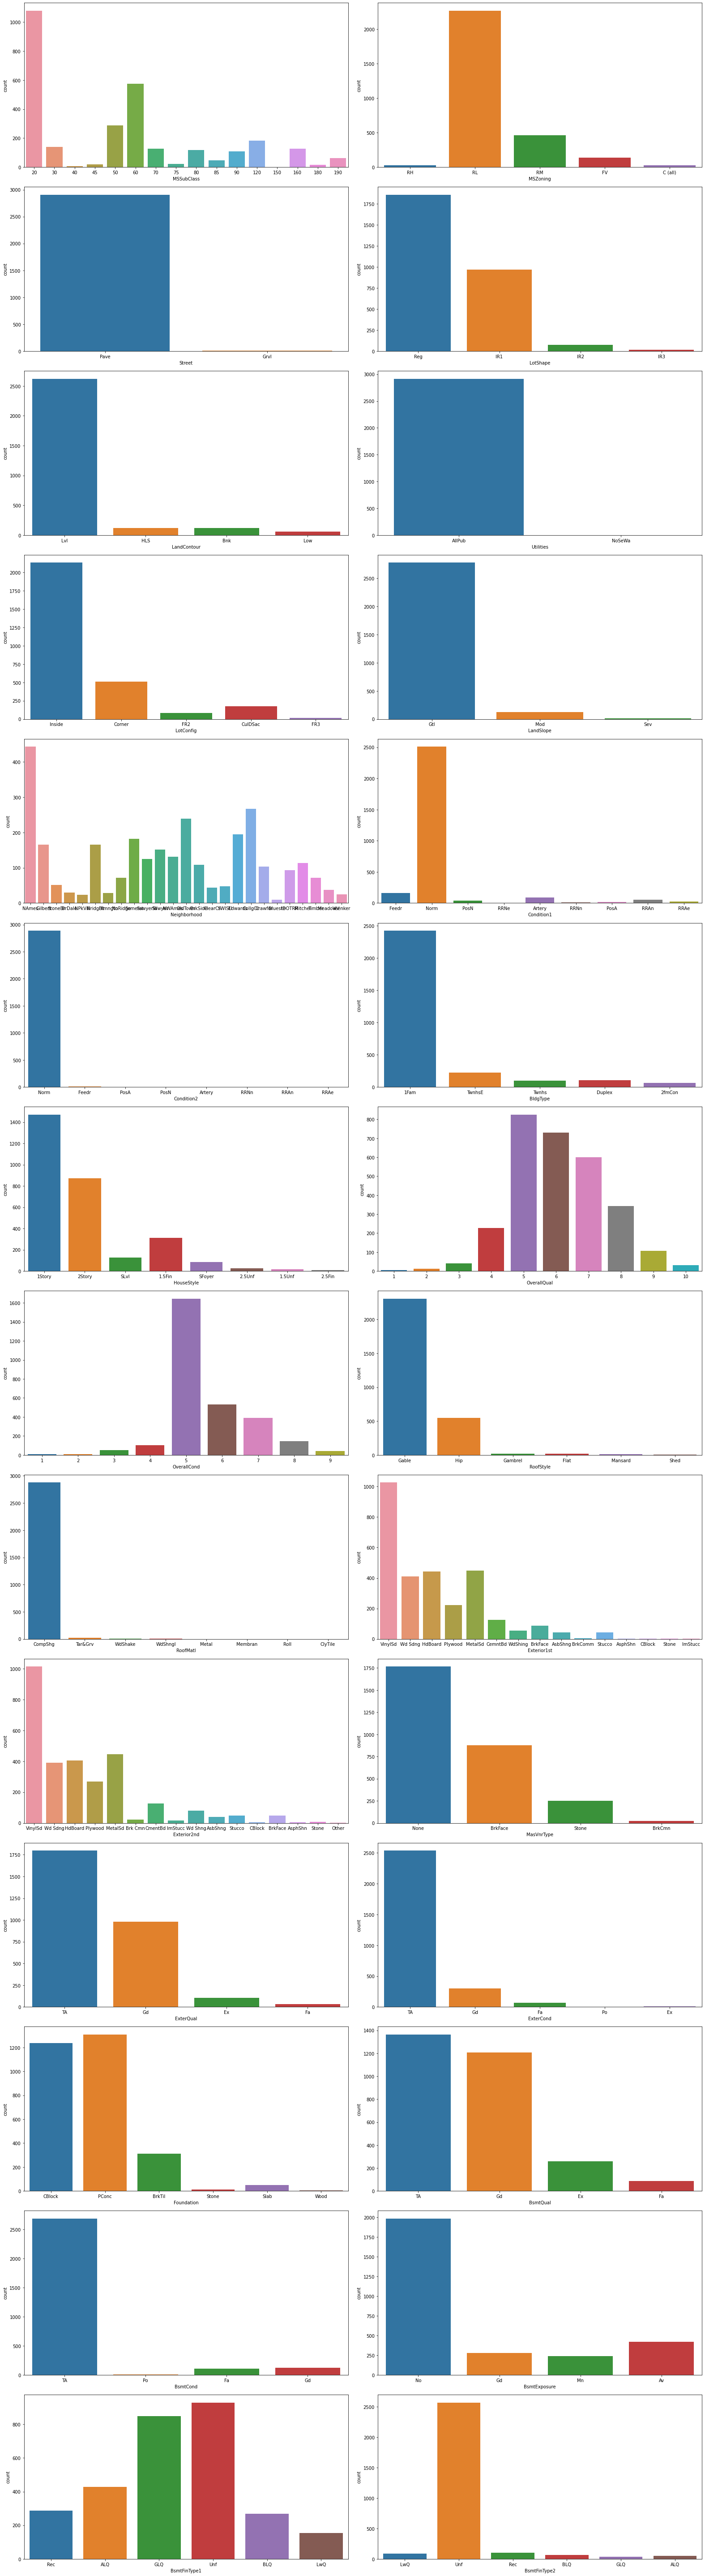

In [9]:
categorical= df.select_dtypes(include='object')

fig, axes = plt.subplots(round(len(categorical.columns) / 3), 2, figsize=(22, 80))

for i, ax in enumerate(fig.axes):
    if i < len(categorical.columns):
        sns.countplot(x=categorical.columns[i], data=categorical, ax=ax)

fig.tight_layout()

Plotting distribution of numeric features

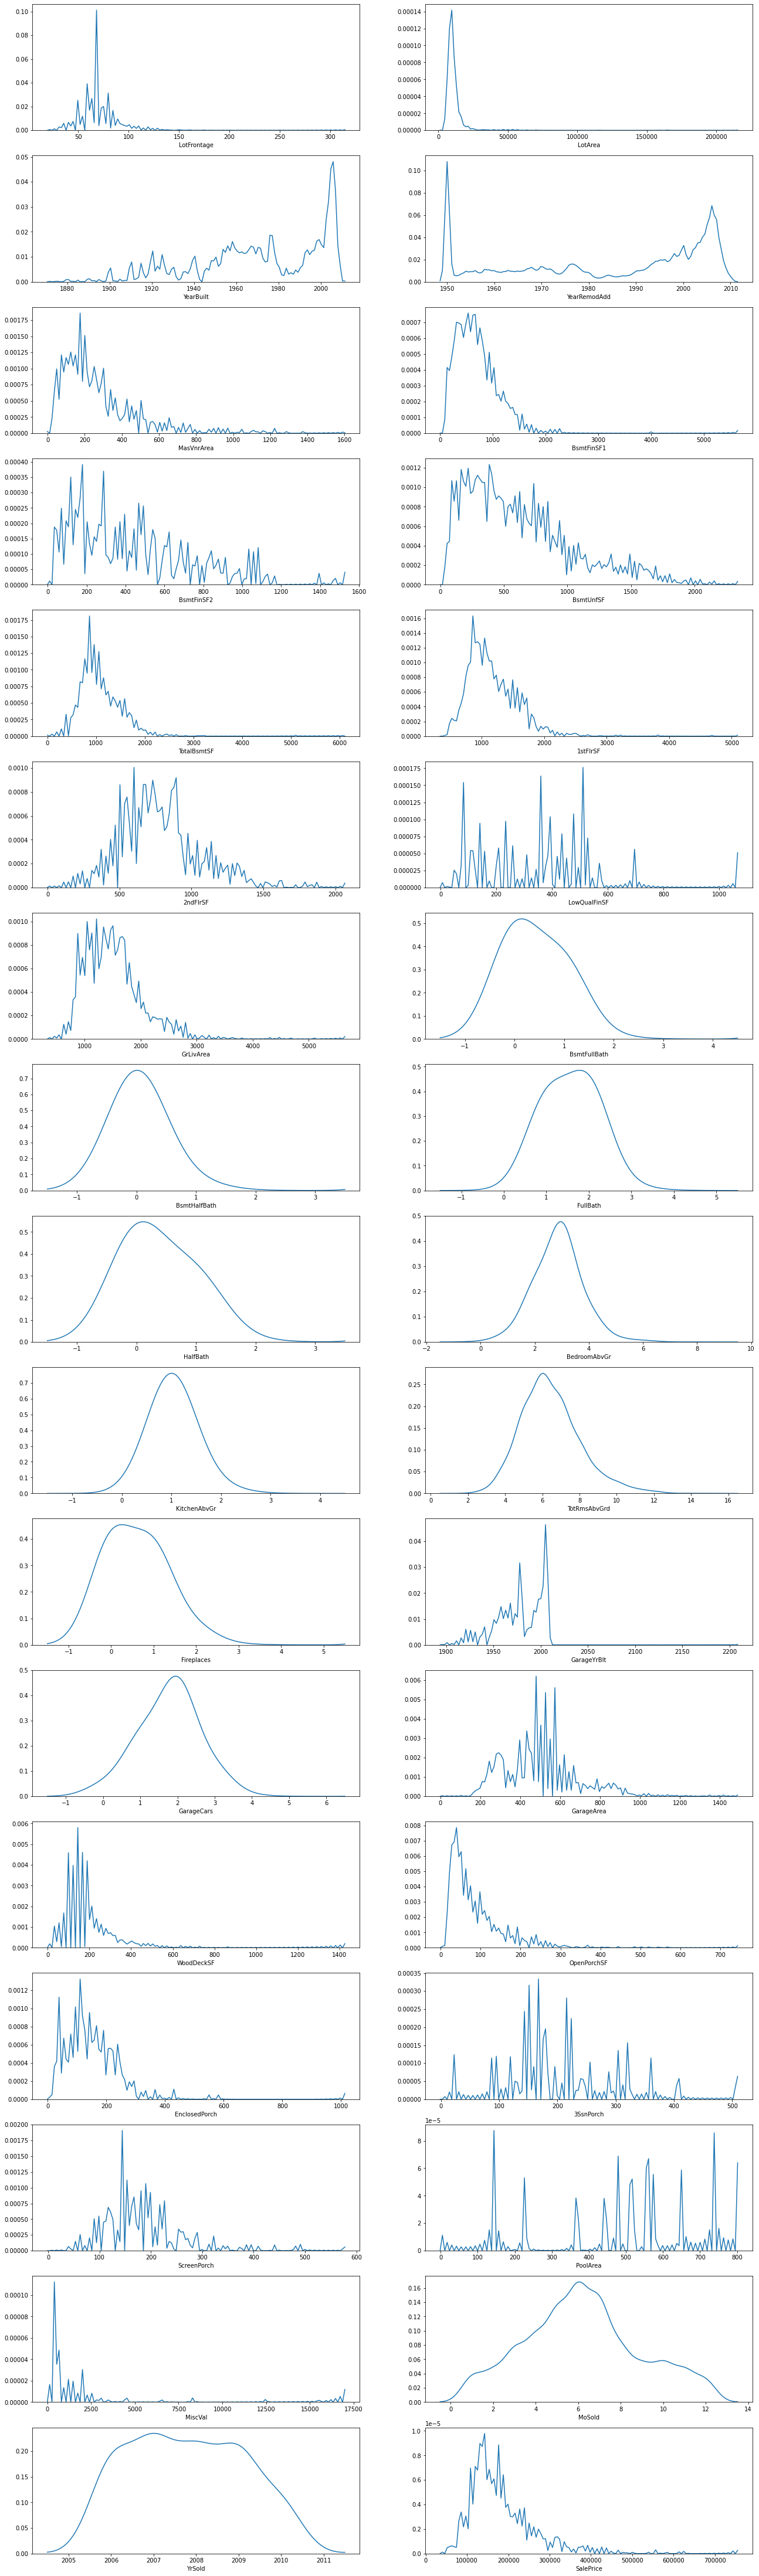

In [10]:
numerics = df.select_dtypes(include=['float64','float32','int64'])
numerics = numerics.drop(['Id'],axis=1)
fig, ax = plt.subplots(17,2,figsize=(22, 80))
for i, col in enumerate(numerics):
    plt.subplot(17,2,i+1)
    plt.xlabel(col, fontsize=10)
    sns.kdeplot(numerics[col].values, bw=0.5)
plt.show() 

Plotting relationship between numerics features and SalePrice

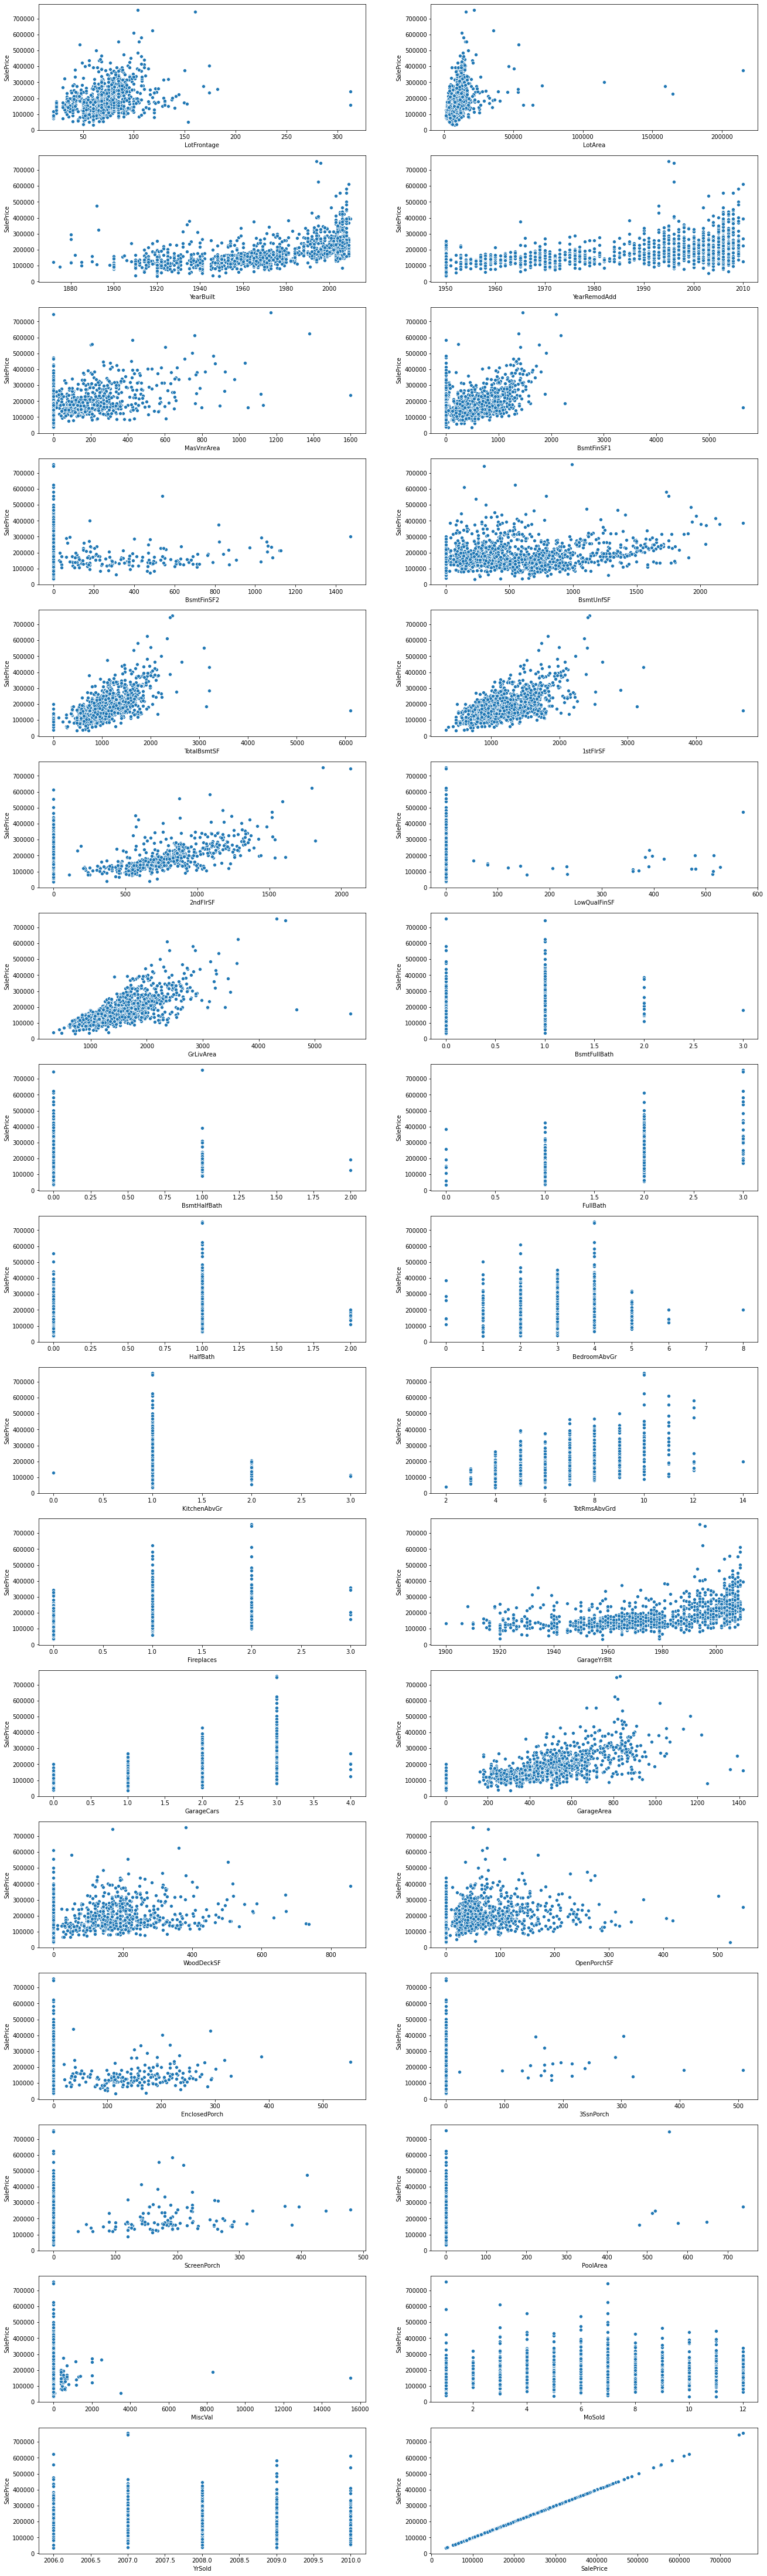

In [11]:
fig, ax = plt.subplots(18,2,figsize=(22,80))
for i, col in enumerate(numerics):
    plt.subplot(17,2,i+1)
    plt.xlabel(col, fontsize=10)
    sns.scatterplot(x=numerics[col].values, y='SalePrice', data=numerics)
plt.show() 

Plotting relationship between categorical features and SalePrice

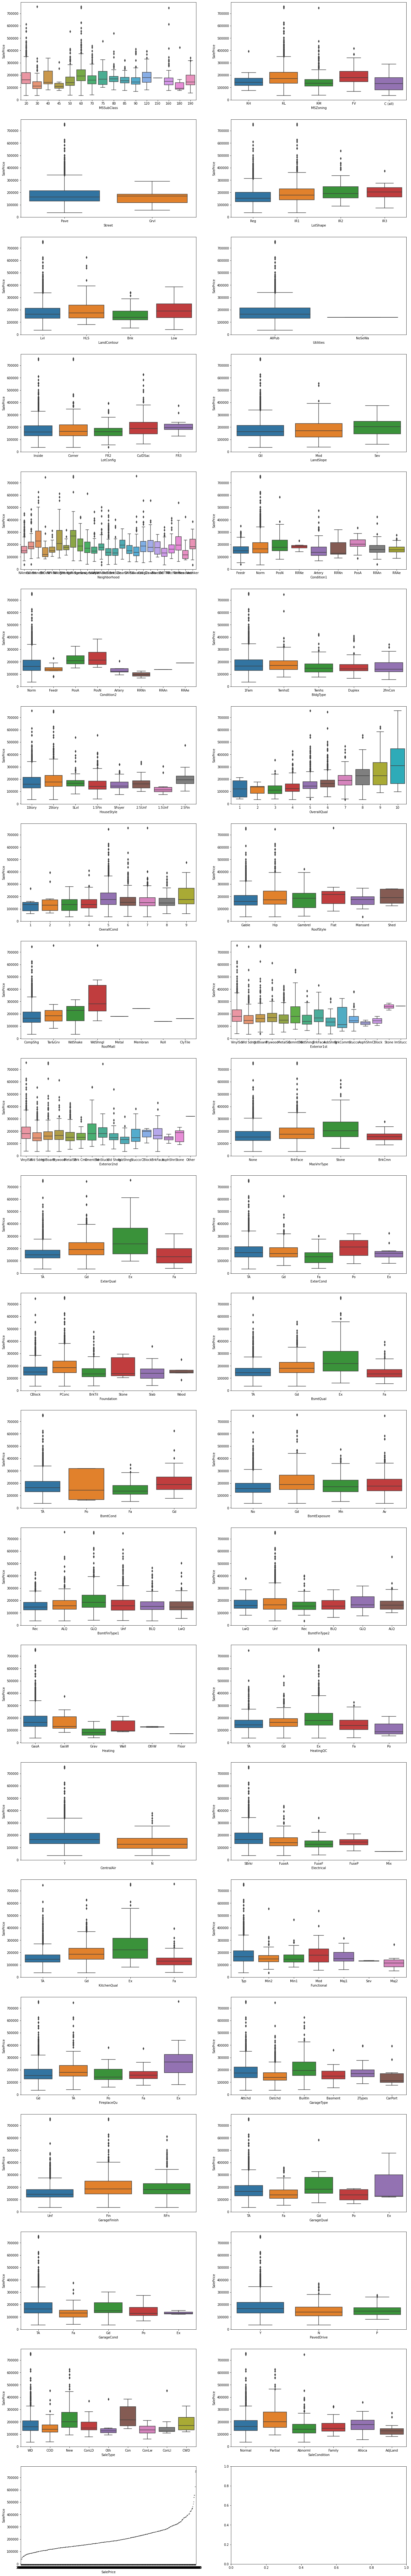

In [12]:
import warnings
warnings.filterwarnings("ignore")
#Plot Categoric features 
categorical = df.select_dtypes(include=['object'])
categorical['SalePrice'] = train.SalePrice
fig, ax = plt.subplots(22,2,figsize=(22,150))
for i, col in enumerate(categorical):
    plt.subplot(22,2,i+1)
    plt.xlabel(col, fontsize=10)
    sns.boxplot(x=categorical.columns[i], y="SalePrice", data=categorical, dodge=False)
plt.show() 

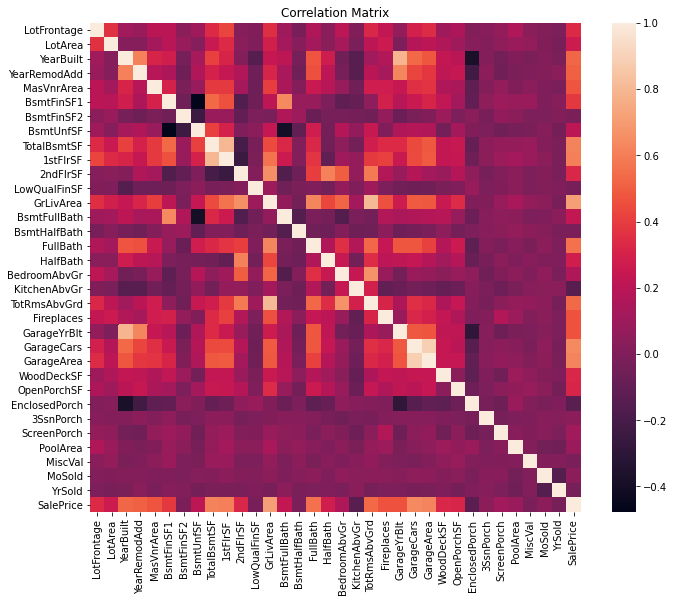

In [13]:
#Check and print the correlation between features and target (top 10 positive correlations)
#Weak positive correlation
df2 = df2.select_dtypes(['float64','int64'])

corr = df2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Matrix')
plt.gcf().set_size_inches(11,9)
plt.show()

### Feature Engineering

### Deal with outliers

In [14]:
print(df.SalePrice.quantile([0.01,0.99]))
print('---')
print(df.SalePrice.describe())
df.SalePrice = np.where(df.SalePrice>442567.0,442567.0,df.SalePrice)
df.SalePrice = np.where(df.SalePrice<61815.97,61815.97,df.SalePrice)

0.01     61815.97
0.99    442567.01
Name: SalePrice, dtype: float64
---
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [15]:
num_col = numerics.columns
for col in df[num_col]:
    df[col]= np.where(df[col]>df[col].quantile(0.99),df[col].quantile(0.99),df[col])
    df[col]= np.where(df[col]<df[col].quantile(0.01),df[col].quantile(0.01),df[col])

In [16]:
df['OverallQual'] = LabelEncoder().fit_transform(df['OverallQual'])

#Create new features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBath'] = df['FullBath']+df['BsmtFullBath']+(df['BsmtHalfBath']+df['HalfBath'])*0.5
df['TotalPorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch']
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['isNewer'] = df['MSSubClass'].apply(lambda x: 1 if x in [20, 60, 120] else 0)

#Encoder in object columsn
for col in df.columns[df.dtypes == 'object']:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

#standard features
num_col = df2.select_dtypes(include=['float64','float32','int64']).columns
num_col = num_col.drop(['SalePrice'])
scaler = sklearn.preprocessing.StandardScaler().fit(df[num_col])
df[num_col]= scaler.transform(df[num_col])

### Split data in test and train 

In [17]:
#train
train = df[df['SalePrice'].isna()==False]

#Valid + submission
x_valid = df[df['SalePrice'].isna()==True]
submission = x_valid['Id'].to_frame()
x_valid = x_valid.drop(['Id'],axis=1)

#x e y
y =train.loc[:,['SalePrice','Id']]
x =train.drop(['SalePrice','Id'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

### 1) Gradient Boosting Regressor

In [18]:
mdl1 = GradientBoostingRegressor(n_estimators = 100)
mdl1.fit(x_train,y_train['SalePrice'])
p = mdl1.predict(x_test) 
print((mean_squared_error(y_test['SalePrice'], p))**0.5)

20465.156809729866


### 2) Random Forest Regressor

In [19]:
mdl2 = RandomForestRegressor(n_estimators = 100)
mdl2.fit(x_train,y_train['SalePrice'])
p2 = mdl2.predict(x_test) 
print((mean_squared_error(y_test['SalePrice'], p2))**0.5)

21394.00286145353


### 3) Ridge regression (L2)

In [20]:
mdl3 = Ridge() 
mdl3.fit(x_train,y_train['SalePrice'])
p3 = mdl3.predict(x_test) 
print((mean_squared_error(y_test['SalePrice'], p3))**0.5)

25499.30011735381


### 4) Lasso regression (L1)

In [21]:
mdl4 = Lasso()
mdl4.fit(x_train,y_train['SalePrice'])
p4 = mdl4.predict(x_test) 
print((mean_squared_error(y_test['SalePrice'], p4))**0.5)

25743.19568848512


### 5) Elastic Net regression

In [22]:
mdl5 = ElasticNet()
mdl5.fit(x_train,y_train['SalePrice'])
p5 = mdl5.predict(x_test) 
print((mean_squared_error(y_test['SalePrice'], p5))**0.5)

24392.58578114889


### Try some feature selection methods in my beste model (Gradient boosting)

Using SelectKbest

In [23]:
select_feature = SelectKBest(f_regression, k=30).fit(x_train, y_train['SalePrice'])
x_train2 = select_feature.transform(x_train)
x_test2 = select_feature.transform(x_test)

mdl6 = GradientBoostingRegressor(n_estimators = 100,random_state=42)
mdl6.fit(x_train2,y_train['SalePrice'])
p = mdl6.predict(x_test2) 
print((mean_squared_error(y_test['SalePrice'], p))**0.5)

23748.82973488843


Using recursive feature elimination

Optimal number of features : 32
Best features : Index(['MSZoning', 'LotArea', 'LotShape', 'LandContour', 'Neighborhood',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'OpenPorchSF',
       'SaleCondition', 'TotalSF', 'TotalBath', 'TotalPorchSF'],
      dtype='object')


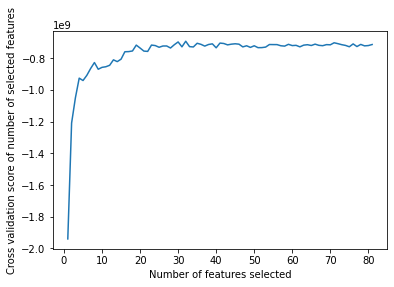

In [24]:
mdl7 = GradientBoostingRegressor(n_estimators = 100)
rfecv = RFECV(estimator=mdl7, step=1, cv=5,scoring='neg_mean_squared_error')  
rfecv = rfecv.fit(x_train, y_train['SalePrice'])

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])
best_features = list(x_train.columns[rfecv.support_])

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
x_train3 = x_train[best_features]
x_test3 = x_test[best_features]

mdl7 = GradientBoostingRegressor(n_estimators = 100,random_state=42)
mdl7.fit(x_train3,y_train['SalePrice'])
p = mdl7.predict(x_test3) 
print((mean_squared_error(y_test['SalePrice'], p))**0.5)

20216.514018471305


### Tuning Hyperparamater using Gridsearch

In [26]:
parameters = {
              'max_features': [0.7,0.8, 0.9],
              'min_samples_leaf' :[1,3,7],
              'learning_rate' : [0.01,0.03,0.1],
               'subsample': [0.8,0.9],
               'max_depth': [5,6,7]
              }


mdl8 = GradientBoostingRegressor(n_estimators = 100,random_state=42)
grid_search2 = GridSearchCV(mdl8, parameters, cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
grid_search2.fit(x_train3,y_train['SalePrice'])

print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 3, 'subsample': 0.8}
-24829.57479687163


### Make submission

In [27]:
x_valid = x_valid[best_features]
SalePrice = mdl7.predict(x_valid)
submission['SalePrice'] = SalePrice  
submission['SalePrice'] = submission['SalePrice']
submission.to_csv('submission.csv' , index=False)